In [2]:
%pip install gymnasium[classic-control]
%pip install tensorflow
%pip install matplotlib
%pip install tqdm

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
import time
from gym import wrappers
from collections import deque
from collections import defaultdict
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
class RLAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        action_space: int,
        discount_factor: float,
        env: gym.Env,
        env_size: 40,

    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            action_space: The number of action for the environment
            discount_factor: The discount factor for computing the Q-value
        """
        self.actions = action_space
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
        self.discrete_size = [env_size] * len(env.observation_space.high)
        self.discrete_win_size = (env.observation_space.high - env.observation_space.low) / self.discrete_size

        #self.q_values = defaultdict(lambda: np.zeros(self.actions))
        self.q_values = np.random.uniform(low=-2, high=0, size=(self.discrete_size + [env.action_space.n]))



    def get_action(self, obs: np.ndarray) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        greedy = random.random() > self.epsilon

        # exploitation
        if greedy:
            obs = self.get_discrete_state(obs)
            # use the train net to get the action value given a state
            return int(np.argmax(self.q_values[obs]))

        # exploration
        else:
             return np.random.choice(self.actions)


    def get_discrete_state(self,state):
        """
        Return a discrete representation of the state, this simplify the learning process
        by reducing the complexity of the state and allow fixed size q-table
        """
        discrete_state = (state - env.observation_space.low) / self.discrete_win_size
        return tuple(discrete_state.astype(np.int))


    def save_qtable(
        self,
        model_name: str,
        episode: int,
    ):
        """
        Saving Q-Tables
        """
        np.save(f'./q_tables/{model_name}/{episode}-qtable.npy', self.q_values)



    def update(
        self,
        obs: np.ndarray,
        action: int,
        reward: float,
        terminated: bool,
        next_obs: np.ndarray,
    ):
        """Updates the Q-value of an action."""

        # convert np.ndarray to hashable object
        obs = self.get_discrete_state(obs)
        next_obs = self.get_discrete_state(next_obs)


        # get the future q_value for the current observation
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])

        # get the difference between current q_value and next observation
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs + (action,)]
        )

        # update the q values for the current obseervation and action
        self.q_values[obs + (action,)] = (
            self.q_values[obs + (action,)] + self.lr * temporal_difference
        )

        # store the training error, the goal is to reduce it
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """ Decay epsilon value by a constant"""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [17]:
def plot_stats(env):
    rolling_length = 500
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    axs[0].set_title("Episode rewards")
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    axs[1].set_title("Episode lengths")
    length_moving_average = (
        np.convolve(
            np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
        )
        / rolling_length
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
    axs[2].set_title("Training Error")
    training_error_moving_average = (
        np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )
    axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
    plt.tight_layout()
    plt.show()


In [23]:
import os
def initialize_directories(model_name):
    """
    Creates new directory in ./q_tables/
    """
    os.mkdir(f'./q_tables/{model_name}')

<ipython-input-19-9f0bb9e2a80c>:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


Episode 0/150000, e 0.500000, avg reward -200.00, state [-4.5584759e-01 -1.4209744e-05], time 200, win 0
Episode 200/150000, e 0.496000, avg reward -200.00, state [-0.8693094   0.01359453], time 200, win 0
Episode 400/150000, e 0.492000, avg reward -200.00, state [-0.51798046  0.03348337], time 200, win 0
Episode 600/150000, e 0.488000, avg reward -200.00, state [-0.49776885  0.02989496], time 200, win 0
Episode 800/150000, e 0.484000, avg reward -200.00, state [-0.40883586 -0.04250878], time 200, win 0
Episode 1000/150000, e 0.480000, avg reward -200.00, state [-0.87844163  0.03030369], time 200, win 0
Episode 1200/150000, e 0.476000, avg reward -200.00, state [0.11936045 0.00833489], time 200, win 0
Episode 1400/150000, e 0.472000, avg reward -200.00, state [-0.82701325 -0.02628474], time 200, win 0
Episode 1600/150000, e 0.468000, avg reward -200.00, state [-0.6875206   0.04278783], time 200, win 0
Episode 1800/150000, e 0.464000, avg reward -200.00, state [-1.0976841  -0.03207711],

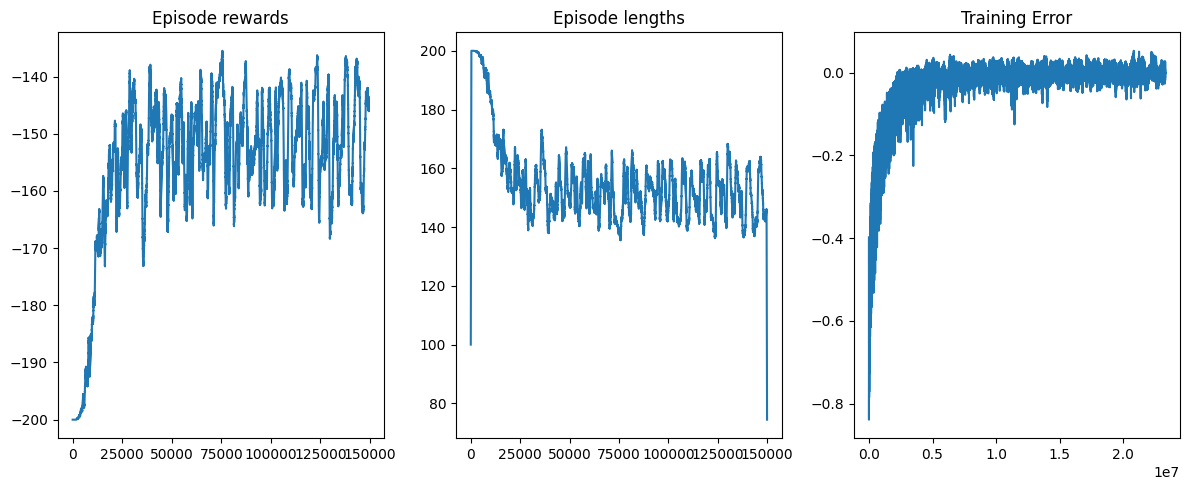

In [25]:
EPISODES = 150_000             # number of episode to play
UPGRADE_STEP =10000            # frequency of target network upgrade
GAMMA = 0.95                  # discount factor
LR = 0.1                      # q-table learning rate
EPS_MAX = 0.5               # Initial exploration probability
EPS_MIN = 0.1           # Final exploration probability
DECAY = 0.00002
DECAY = EPS_MAX // (EPISODES - 1)

# Start with high exploration probability
epsilon = EPS_MAX

reward_sum = 0
win = 0
scores = list()

model_name = f'LR: {LR} - DISCOUNT: {GAMMA} -' \
             f' EPISODES: {EPISODES}'\
             f' EPSILON: {epsilon}'

initialize_directories(model_name)

env = gym.make('MountainCar-v0')
agent = RLAgent(
    learning_rate=LR,
    initial_epsilon=EPS_MAX,
    epsilon_decay=DECAY,
    final_epsilon=EPS_MIN,
    action_space=env.action_space.n,
    discount_factor=GAMMA,
    env=env,
    env_size=40,
)

reward_sum = 0
win = 0
time_scores = deque(maxlen=100)


env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=EPISODES)
#for episode in tqdm(range(EPISODE)):
for episode in range(EPISODES):
    obs, info = env.reset()
    done = False

    step = 1
    # play one episode
    while not done:

        # get an action according to epsilon greedy policy
        action = agent.get_action(obs)

        # execute the action
        next_obs, reward, terminated, truncated, info = env.step(action)


        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated

        # upgrade to next obs
        obs = next_obs

        if done:

            # store current time for that episode
            time_scores.append(step)

            # compute avg score
            scores_avg = np.mean(time_scores) * -1

            # if goal increase number of win
            if next_obs[0] >= 0.5:
                win += 1

            if episode % 200 == 0:
                print(f"Episode {episode}/{EPISODES}, e {agent.epsilon:.6f}, avg reward {scores_avg:.2f}, state {next_obs}, time {step}, win {win}")
            break

        # increment step
        step+=1

    # Save progress every UPGRADE STEP
    if episode % UPGRADE_STEP == 0 and episode > 0:
        agent.save_qtable(model_name,episode)

    agent.decay_epsilon()

# plot stats
plot_stats(env)